## Logistic Regression 模型假設

1. **目標變數為二元類別（Binary）**
2. **自變數與 log odds 之間呈線性關係**
3. **自變數間應避免多重共線性（Multicollinearity）**
4. **選用具意義之特徵進行模型訓練**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [19]:
# 讀取資料
data=pd.read_csv('banking.csv')
data.head() #查看前5筆

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [20]:
data.columns #查看欄位

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [21]:
data.info() #查看基本欄位資料

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [22]:
data['y'].value_counts() #查看y欄位資料

,count
y,
0,36548
1,4640


In [23]:
data.groupby('job').mean(numeric_only=True)
data.groupby('y').mean(numeric_only=True)


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


## 類別變數視覺化

### 使用 `pd.crosstab` + `plot(kind='bar')` 進行分析

<Axes: xlabel='education'>

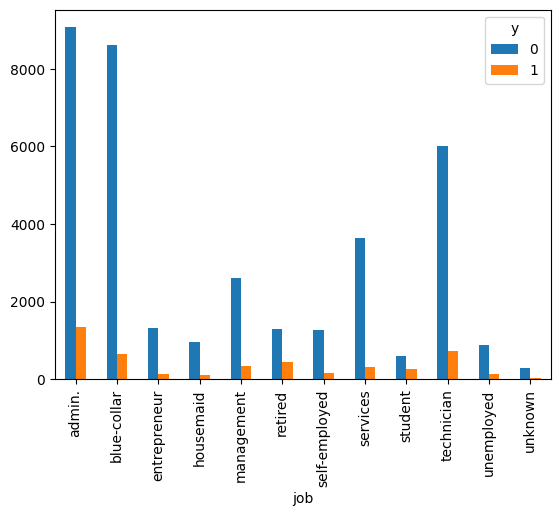

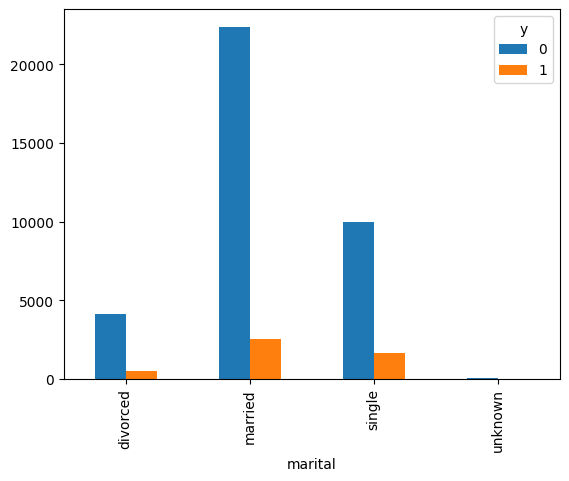

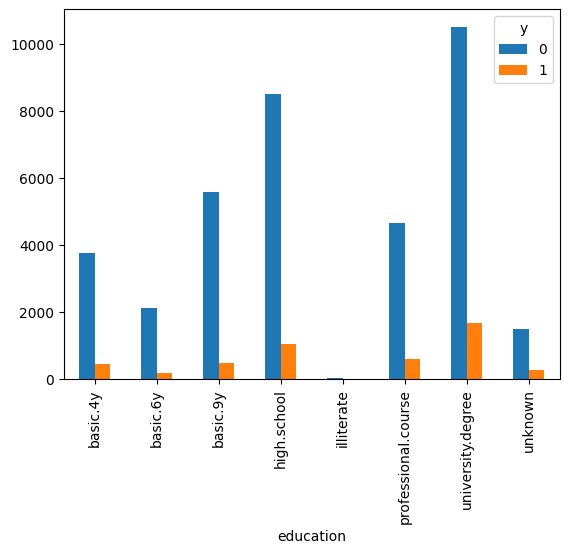

In [24]:
pd.crosstab(data['job'], data['y']).plot(kind='bar')
pd.crosstab(data['marital'], data['y']).plot(kind='bar')
pd.crosstab(data['education'], data['y']).plot(kind='bar')

<Axes: >

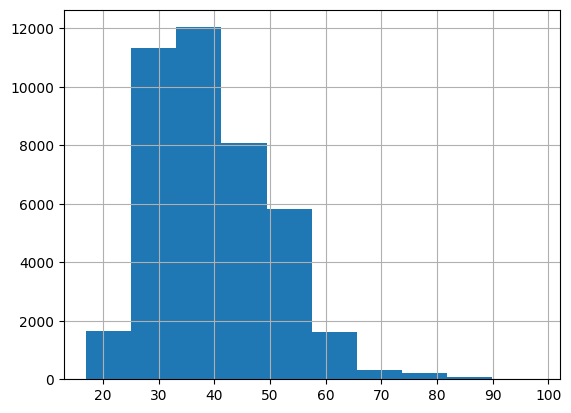

In [25]:
data['age'].hist() #查看資料分佈, 以'age'為例

## 特徵轉換：One-hot Encoding

### 將類別型欄位轉換為數值型

1. `pd.get_dummies(data)`

  - 將 data 內所有類別型欄位（例如性別、地區等）轉換成數值 0/1 欄位。

  - 每個原本的類別會變成一個新的欄位。

  例如：

  性別: [男, 女, 男]


  轉換後：

  性別_男  性別_女

    1       0

    0       1

    1       0


2. drop_first=True

  為避免 dummy variable trap（多重共線性），會自動丟掉每個類別欄位的第一個 dummy 欄位。

  例如上例，轉換後只會留下：

  性別_女

    0

    1

    0


（0 代表「男」，1 代表「女」）

In [26]:
data_final = pd.get_dummies(data, drop_first=True)

## 解決類別不平衡：SMOTE

### 使用 `SMOTE` 重採樣

定義並套用 SMOTE
```python
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
```

輸出平衡後的訓練集 x_train_resampled 和 y_train_resampled。

### 關鍵效果

- 原本 `y_train` 可能是：
    
    ```
    類別 0: 800 筆
    類別 1: 200 筆
    
    ```
    
- 過採樣後 `y_train_resampled`：
    
    ```
    類別 0: 800 筆
    類別 1: 800 筆  ← SMOTE 合成的新資料
    
    ```

In [27]:

from imblearn.over_sampling import SMOTE

x = data_final.drop('y', axis=1)
y = data_final['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

sm = SMOTE()
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

## 特徵選取：RFE（Recursive Feature Elimination）

### 遞迴特徵消除法

In [28]:
from sklearn.feature_selection import RFE

# 選出對預測最有貢獻的 20 個特徵
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=20)
fit = rfe.fit(x_train_resampled, y_train_resampled)

selected_features = x.columns[fit.support_]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [29]:
## 建模與預測

### 使用選定特徵訓練 Logistic Regression 模型

## 模型評估

### 準確率（Accuracy）

In [37]:
x_train_sel = x_train_resampled[selected_features]
x_test_sel = x_test[selected_features]

model.fit(x_train_sel, y_train_resampled)
y_pred = model.predict(x_test_sel)


[0 0 0 ... 0 0 0]


## 評估指標一：Accuracy（準確率）

### 定義

Accuracy=(正確預測數量)/(總預測數量)Accuracy = (正確預測數量) / (總預測數量)

### 適用情境

- **類別平衡**（balanced class）問題
- 二元或多元分類皆可使用

### 不適用情境

- **類別不平衡**問題容易導致誤判。例如：
    - 假設有 10,000 筆資料，其中只有 100 筆為正例（詐欺）
    - 若模型永遠預測為負例，仍有 99% 的 Accuracy，但實際預測無效

---

## 評估指標二：Confusion Matrix（混淆矩陣）

### 定義與結構

|實際值＼預測值|預測為 0|預測為 1|
|---|---|---|
|實際為 0|TN|FP|
|實際為 1|FN|TP|

- **TP**（True Positive）：實際為 1，預測也為 1
- **TN**（True Negative）：實際為 0，預測也為 0
- **FP**（False Positive）：實際為 0，預測為 1
- **FN**（False Negative）：實際為 1，預測為 0

### 應用情境範例

- 健康診斷中，**False Negative（漏判病人）風險遠高於 False Positive**
- 所以應偏好 **Recall 較高** 的模型

---

## 評估指標三：Precision、Recall、F1 Score

### 1. Recall（召回率）

Recall=TP/(TP+FN)Recall = TP / (TP + FN)

- 衡量模型找出「所有實際正例」的能力
- 與「漏判率」呈反比

### 2. Precision（精確率）

Precision=TP/(TP+FP)Precision = TP / (TP + FP)

- 衡量模型所預測正例中有多少是真正正例
- 與「誤判率」呈反比

### 3. F1 Score

F1=2∗(Precision∗Recall)/(Precision+Recall)F1 = 2 * (Precision * Recall) / (Precision + Recall)

- **調和平均數**，平衡 Precision 與 Recall
- 適用於資料偏斜、同時關注誤判與漏判的情況

In [31]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)  # 結果：約 0.88

0.8752124302015052


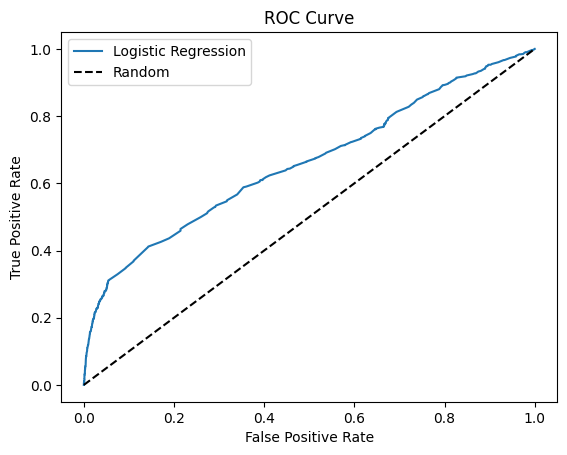

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

# 模型機率輸出
y_pred_proba = model.predict_proba(x_test_sel)[:, 1]

# 計算 ROC AUC 分數
roc_auc_score(y_test, y_pred_proba)

# 計算 TPR, FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 繪圖
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

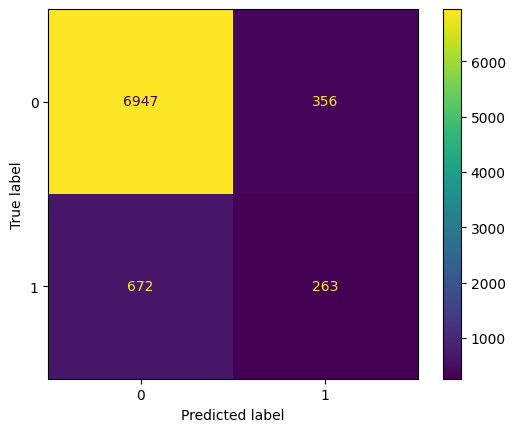

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_test, y_pred)
recall_score(y_test, y_pred)
f1_score(y_test, y_pred)


0.3384813384813385